# Phase 1 Model Selection

## Objective:
The primary objective of this notebook is to perform a comprehensive analysis of the experimental results from Phase 1. Based on this analysis, we will select a single, optimal model to advance to Phase 2, which involves training on the full dataset, followed by deployment to a Hugging Face Space.

This selection process is critical for ensuring that our final production model is not only accurate but also efficient and practical for real-world application.

## The "Success" Metrics: A Multi-Criteria Decision Framework:
To ensure a robust and data-driven model selection, we define a set of success criteria that a candidate model must satisfy. A model is deemed "suitable" for production if and only if it meets all three of the following requirements. This multi-criteria framework balances the trade-off between predictive performance and operational efficiency.

**Our selection criteria are defined as follows:**

**1/ Predictive Performance (Accuracy):**

- **Requirement:** The model must achieve a test_accuracy of **≥ 80%** on the 20% data subset.

- **Rationale:** This threshold serves as a baseline for acceptable predictive power. A model failing to meet this criterion is unlikely to generalize well on the full dataset, making it unsuitable for our use case.

**2/ Inference Latency (Speed):**

- **Requirement:** The average inference time per image must be **< 33ms**.

- **Rationale:** This latency target corresponds to a throughput of approximately **30 frames per second (FPS)**, a standard benchmark for real-time or near-real-time applications. Low latency is crucial for a positive user experience and for building scalable services. We will measure this on a target hardware profile (e.g., CPU or a specific GPU like T4).

**3/ Resource Footprint (Model Size):**

- **Requirement:** The model's on-disk size must be compact. While there is no absolute threshold, we will perform a **relative comparison** among the candidates that satisfy the first two criteria.

- **Rationale:** A smaller model size leads to significant operational advantages, including faster download times, lower memory consumption (both on the server and on-device), and reduced deployment costs. This is particularly important for edge deployments or containerized services on platforms like Hugging Face.

Our investigation will proceed in three key steps:

1/ Performance Analysis (Accuracy & Loss):
> We will visualize the training curves and compare the peak accuracy achieved by each of the four candidate models (EfficientNet, ConvNeXt, MobileNetV2, and ViT).

2/ Efficiency Analysis (Size & Speed):
> We will then benchmark the models on two critical efficiency metrics: the number of parameters (model size) and the average inference speed.

3/ Trade-off Analysis & Final Decision Matrix:
> Finally, we will synthesize all findings into a single decision matrix. This will allow us to perform a clear trade-off analysis and select the one model that best satisfies all our predefined criteria for Phase 2.

## 00. Import base libraries

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
from IPython.display import display

from src.helper_functions import plot_model_comparison_curves_enhanced
from src.utils import analyze_and_visualize_efficiency, plot_tradeoff_scatter

## 01. Performance Analysis (Accuracy & Loss)

### 01.1 Loading and preparing the results

In this section, we will load the training performance data from the `.csv` files generated during Phase 1. Each model's results will be loaded into a separate Pandas DataFrame and stored in a dictionary for easy access during the analysis.

In [2]:
# --- 1. Setup ---

# Define the directory where the Phase 1 results are stored.
# We use pathlib for robust path handling that works across different operating systems.
# The "../" goes up one directory level from our current location ('notebooks/') to the project root.
results_dir = Path("../results/")
# Print the path to confirm it's correct
print(f"Looking for results in: {results_dir}")

# --- 2. Load Data into Separate DataFrames ---

# First, check if the results directory actually exists to provide a helpful error message.
if not results_dir.exists():
    print(f"Error: Results directory not found at '{results_dir}'")
    print("Please make sure you have run the training script and the CSV files are in the correct location.")
else:
    # Create an empty dictionary to store each model's DataFrame.
    # This is a clean way to manage multiple DataFrames.
    model_results = {}

    # Find all files in the directory that end with .csv
    csv_files = list(results_dir.glob("*.csv"))
    print(f"\nFound {len(csv_files)} CSV result files.")

    # Loop through each found CSV file
    for file_path in csv_files:
        # Extract the model name from the filename for use as a key.
        # Example: "efficientnet_b2_phase1_results.csv" -> "efficientnet_b2"
        # .stem gets the filename without the .csv extension
        model_name = file_path.stem.replace("_phase1_results", "")

        # Read the CSV file into a Pandas DataFrame
        df = pd.read_csv(file_path)

        # Store the DataFrame in our dictionary with the model name as the key
        model_results[model_name] = df

        print(f"-> Successfully loaded results for: '{model_name}'")

# --- 3. Verification ---

# Check the keys (model names) in our dictionary
print("\nModels loaded into the `model_results` dictionary:", list(model_results.keys()))

# Display the first few rows of each DataFrame to verify the data
for model_name, df in model_results.items():
    print(f"\n--- Data for: {model_name} ---")
    # Using display() in Jupyter provides a nicer table format than print()
    display(df)

Looking for results in: ..\results

Found 4 CSV result files.
-> Successfully loaded results for: 'convnext_tiny'
-> Successfully loaded results for: 'efficientnet_b2'
-> Successfully loaded results for: 'mobilenet_v2'
-> Successfully loaded results for: 'vit_b_16'

Models loaded into the `model_results` dictionary: ['convnext_tiny', 'efficientnet_b2', 'mobilenet_v2', 'vit_b_16']

--- Data for: convnext_tiny ---


,train_loss,train_acc,test_loss,test_acc,epoch
0,1.288304,0.668978,0.593223,0.859375,0
1,0.535434,0.880984,0.390452,0.905078,1
2,0.394065,0.888773,0.321793,0.922266,2
3,0.317221,0.909384,0.295048,0.919531,3
4,0.275489,0.921163,0.283943,0.921875,4
5,0.234944,0.935125,0.266490,0.927344,5
6,0.212391,0.944719,0.270523,0.918750,6
7,0.186371,0.956022,0.261999,0.925781,7
8,0.171759,0.956782,0.254744,0.928125,8
9,0.151831,0.968085,0.248319,0.929297,9



--- Data for: efficientnet_b2 ---


,train_loss,train_acc,test_loss,test_acc,epoch
0,1.889774,0.472454,1.428408,0.774219,0
1,1.250333,0.733188,1.039793,0.811328,1
2,0.951166,0.787329,0.867411,0.823828,2
3,0.816824,0.804616,0.753929,0.823828,3
4,0.733566,0.817154,0.698240,0.830469,4
5,0.648898,0.839381,0.643278,0.834375,5
6,0.616555,0.836626,0.609334,0.825781,6
7,0.551408,0.865881,0.600193,0.831641,7
8,0.519469,0.865881,0.576571,0.828906,8
9,0.493650,0.873195,0.562912,0.829688,9



--- Data for: mobilenet_v2 ---


,train_loss,train_acc,test_loss,test_acc,epoch
0,1.930579,0.465331,1.527384,0.698047,0
1,1.312593,0.719795,1.129232,0.750391,1
2,1.008290,0.787994,0.936409,0.785547,2
3,0.878489,0.796638,0.833595,0.803125,3
4,0.773797,0.822378,0.767488,0.809766,4
5,0.713041,0.818009,0.725507,0.802344,5
6,0.648126,0.840141,0.690544,0.812109,6
7,0.597973,0.855528,0.632821,0.830078,7
8,0.559229,0.853533,0.628505,0.822266,8
9,0.533056,0.861512,0.605172,0.826172,9



--- Data for: vit_b_16 ---


,train_loss,train_acc,test_loss,test_acc,epoch
0,1.124200,0.691679,0.567250,0.826562,0
1,0.484662,0.856953,0.431653,0.860938,1
2,0.370044,0.890578,0.369944,0.885547,2
3,0.303735,0.923347,0.337583,0.889453,3
4,0.258659,0.936550,0.324886,0.893359,4
5,0.221147,0.946334,0.312966,0.893359,5
6,0.192015,0.964001,0.307302,0.898047,6
7,0.168637,0.969415,0.302053,0.891016,7
8,0.149797,0.976064,0.290347,0.899219,8
9,0.136983,0.975874,0.289030,0.899219,9


### 01.2 Performance showdown: a head-to-head model comparison

Now, we will conduct a head-to-head comparison to see how our four candidate models performed. The following charts visualize the **Test Loss** and **Test Accuracy** curves for all models on the same axes.

This direct comparison is the first step in our selection process, allowing us to quickly identify the top performers based on their ability to generalize to unseen data. We are looking for models that achieve a low, stable loss and a high, consistent accuracy.

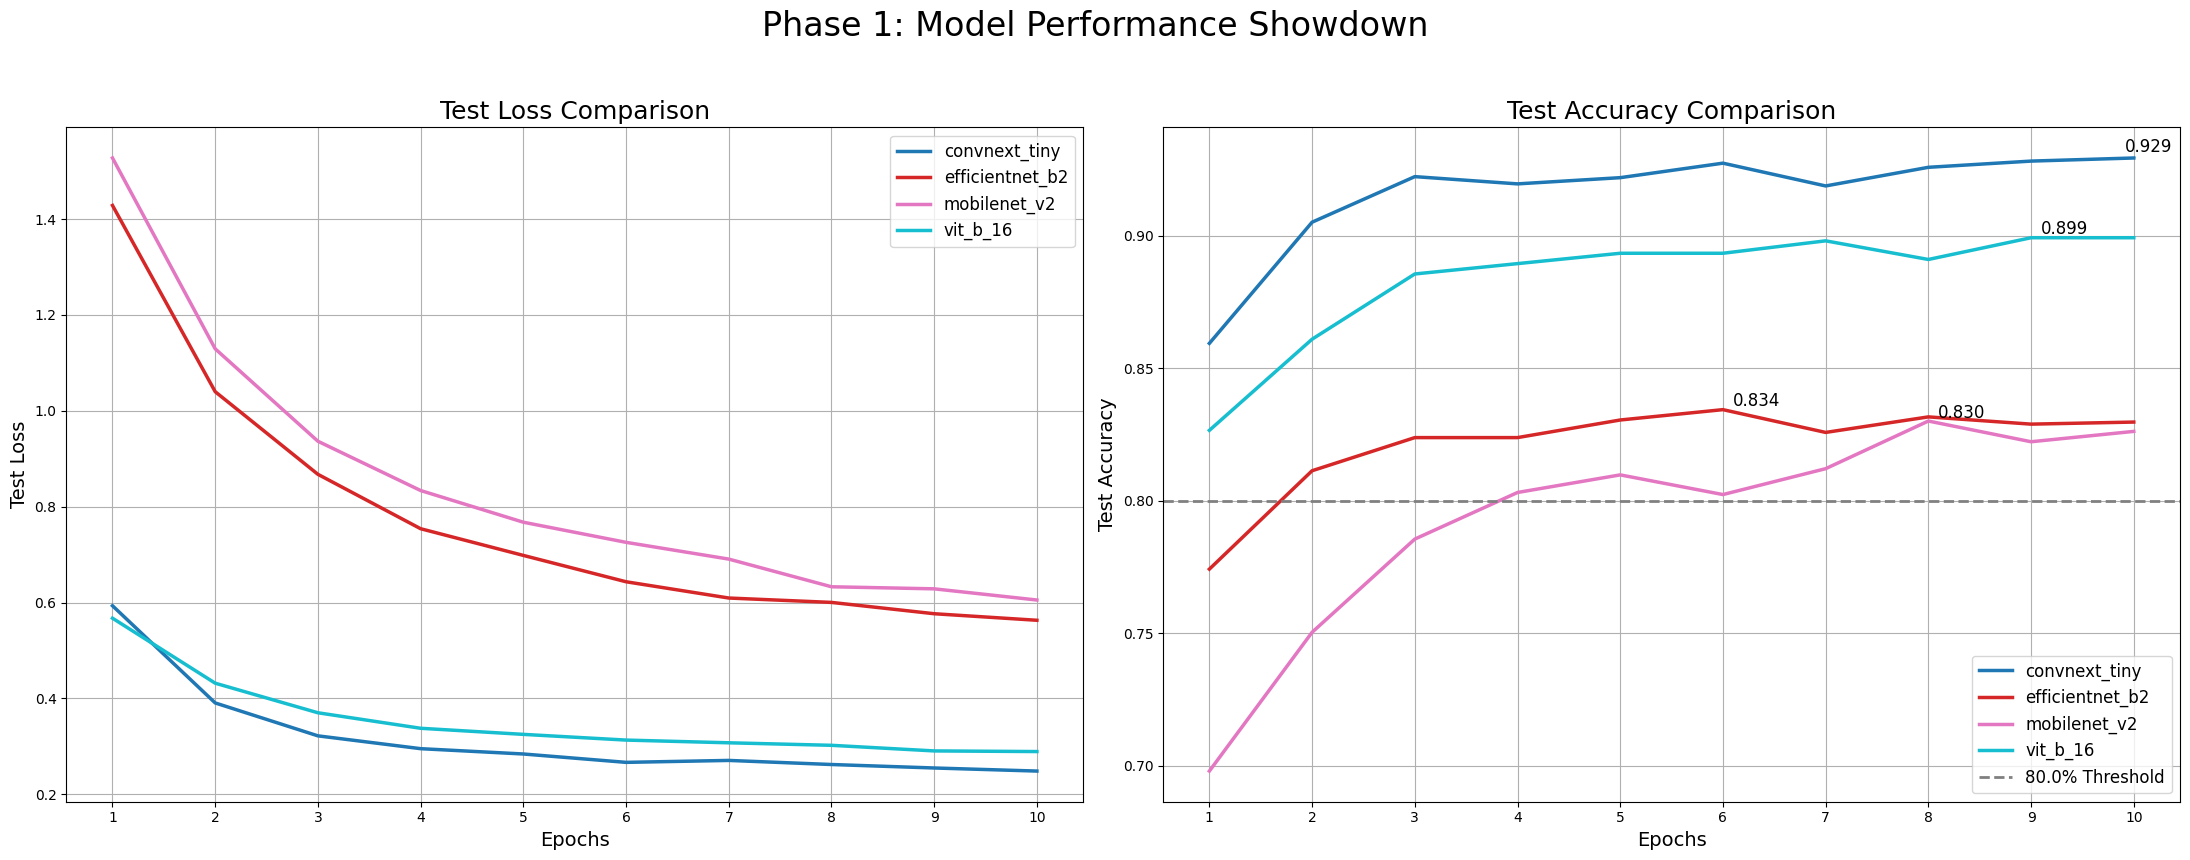

Performance Summary Table


,Lowest Test Loss,Epoch (Loss),Best Test Acc (%),Epoch (Acc)
Model,,,,
convnext_tiny,0.2483,10,92.93%,10
efficientnet_b2,0.5629,10,83.44%,6
mobilenet_v2,0.6052,10,83.01%,8
vit_b_16,0.2890,10,89.92%,9


In [3]:
# Visualize the performance of all four models from the Phase 1 experiment.
# This utility function plots the Test Loss and Test Accuracy curves over epochs,
# allowing for a direct comparison of their learning dynamics and stability.
# The 85% accuracy threshold is also rendered to immediately identify which models meet our primary performance criterion.
plot_model_comparison_curves_enhanced(model_results = model_results)

**Performance Analysis Observations:**

> With the adjusted success criterion of **>80% test accuracy**, all four candidate models have now successfully met the performance requirement. However, a closer look at the results reveals two distinct tiers of performance:
>- Top Performers: `convnext_tiny` and `vit_b_16` clearly stand out from the rest, achieving impressive peak accuracies of 92.9% and 89.9% respectively. They represent the high-end of performance in this experiment.
>- Qualified Candidates: `efficientnet_b2` (83.4%) and `mobilenet_v2` (83.0%) also solidly met the threshold. While their accuracy is lower than the top performers, they have successfully established themselves as viable options for further consideration.

**Next Step:** While the accuracy results now present more options, our final decision is incomplete without considering the critical requirements of **model size** and **inference speed**. The next section will perform an efficiency analysis to determine which of these four qualified models offers the best overall balance for deployment.

## 02. Efficiency Analysis (Size & Speed)

Having analyzed the performance in terms of accuracy, we now shift our focus to efficiency. A model is only viable for our deployment goal if it meets the strict criteria for size and speed.

A critical consideration for this benchmark is the choice of hardware. While model training was accelerated on a **GPU**, the final application on Hugging Face will likely run on **CPU-based hardware** for the majority of users. Therefore, to realistically estimate real-world performance, **we will conduct our inference speed tests exclusively on the CPU**.

Our analysis will focus on two key efficiency metrics:

- **Model Size:** Calculated from the total number of parameters and the resulting storage footprint in Megabytes (MB).

- **Inference Speed:** Benchmarked as the average time in milliseconds (ms) to classify a single image on a CPU.

--- Running Efficiency Analysis on device: 'cpu' ---
Analyzing model: efficientnet_b2...
Analyzing model: convnext_tiny...
Analyzing model: mobilenet_v2...
Analyzing model: vit_b_16...


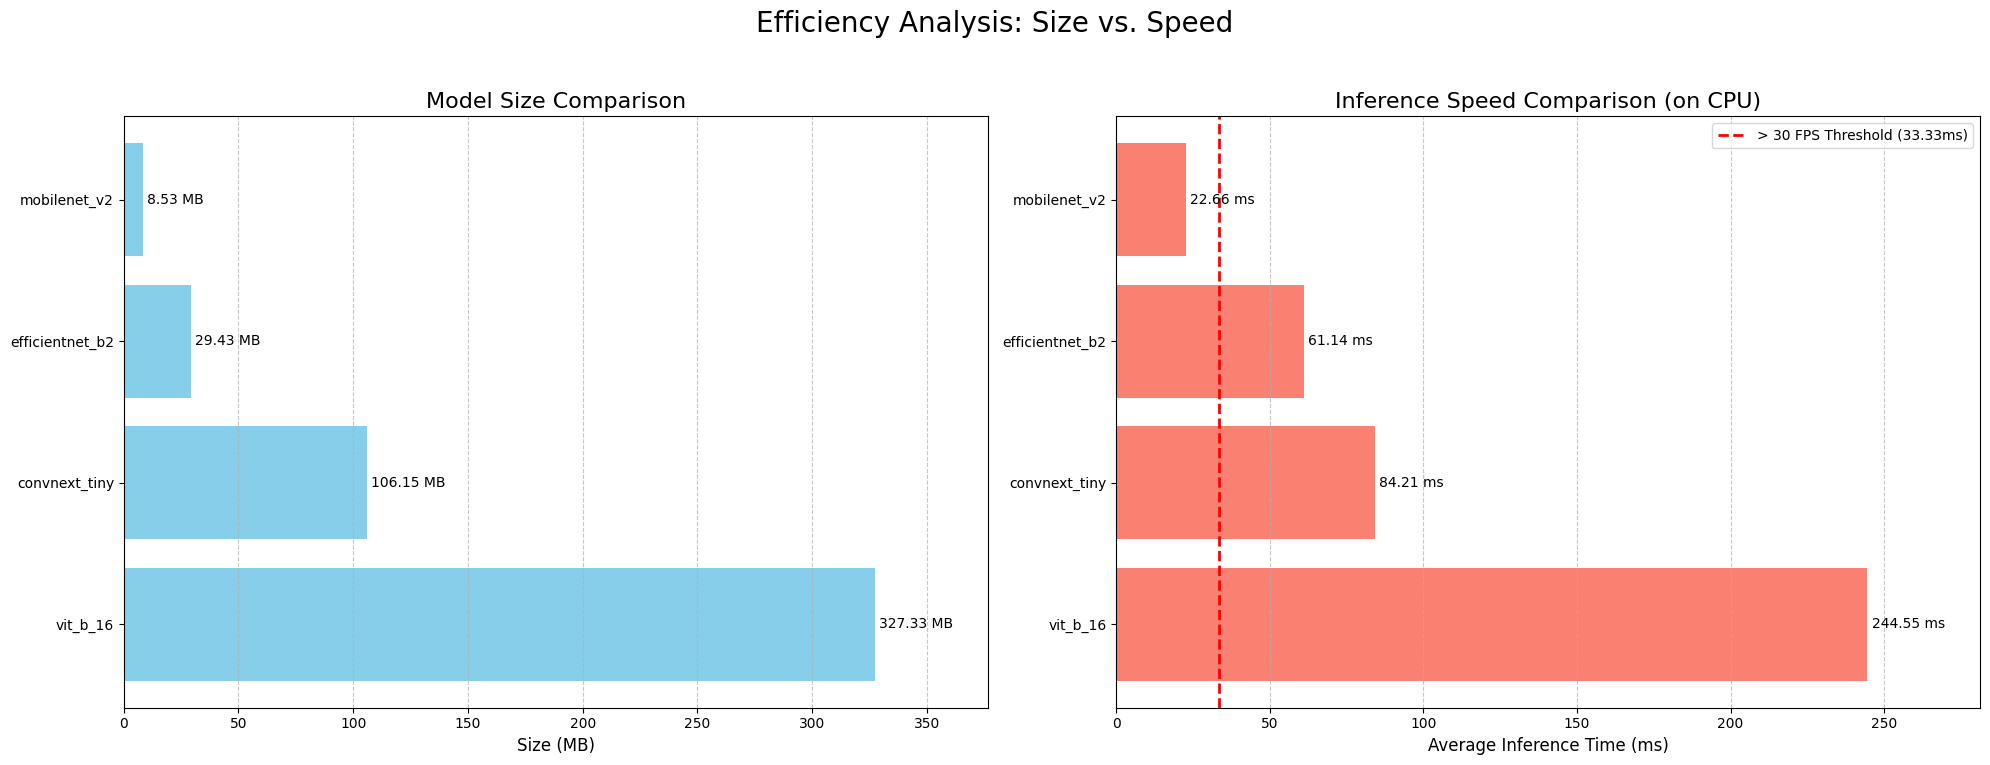


Efficiency Analysis Summary


,Parameters (M),Size (MB),Avg Inference (ms) on CPU
Model,,,
efficientnet_b2,7.72,29.43,61.14
convnext_tiny,27.83,106.15,84.21
mobilenet_v2,2.24,8.53,22.66
vit_b_16,85.81,327.33,244.55


In [4]:
# --- 1. Load Configuration from YAML ---

# Define the path to the config file we used for training
config_path = Path("../configs/phase1_config.yml")

# Load the configuration
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Extract the model names and num_classes directly from the config
model_configs = config['model_configs']
model_names = [model['name'] for model in model_configs]
num_classes_phase1 = config['data_params']['num_classes']

# --- 2. Run the Analysis ---

# Call our single, powerful utility function to do all the work.
# It will run the benchmark, plot the charts, and display the styled table.
# We also capture the returned DataFrame for the next section.
efficiency_df = analyze_and_visualize_efficiency(
    model_names=model_names,
    num_classes=num_classes_phase1,
    device="cpu" # Explicitly benchmark on CPU
)


**Efficiency Analysis Observations:**

> The efficiency analysis provides a clear and decisive picture regarding our "lightweight" and "fast" criteria. The bar charts and the summary table highlight an obvious contrast among the candidate models:
>- A Clear Winner in Efficiency: `mobilenet_v2` is the undisputed leader in efficiency. It is the only model to meet our **> 30 FPS requirement**, clocking in at an impressive **22.666 ms** per inference on a CPU. Furthermore, it is also, by a significant margin, the **most lightweight model** at only **8.53 MB**.
>- Other Contenders: All other models (`efficientnet_b2`, `convnext_tiny`, and `vit_b_16`) failed to meet the critical inference speed threshold, making them unsuitable for our real-time deployment goal despite their high accuracy.

**Next step:** We have now evaluated our models on two distinct axes: **performance (accuracy)** and **efficiency (size/speed)**. While all four models successfully passed our 80% accuracy threshold, the efficiency analysis has revealed a clear frontrunner. The final step is to synthesize these findings in a **trade-off analysis** to definitively determine which model offers the best overall balance for our deployment goals.

## 03. Trade-off Analysis & Final Decision Matrix

The preceding analyses have established that while all four models meet our baseline 80% accuracy target, they exhibit vastly different efficiency profiles. The **Performance Analysis** identified `convnext_tiny` and `vit_b_16` as the top performers in terms of accuracy, while the **Efficiency Analysis** demonstrated that `mobilenet_v2` is the only model to meet our critical requirement for real-time inference speed (> 30 FPS).

To resolve this classic engineering trade-off, this final section will synthesize all key metrics into a single, unified view. We will first construct a **Decision Matrix** to quantitatively compare all models across all criteria. Following this, we will create a **trade-off scatter plot** to visually map each model's position in the performance-efficiency landscape. Together, these tools will enable us to make a definitive, evidence-based selection for the model to be advanced to Phase 2.

In [5]:
# =====================================================================
#  Section 3: Trade-off Analysis & Final Decision Matrix
# =====================================================================

# --- 1. Consolidate All Metrics into a Single DataFrame ---

# Get the best test accuracy for each model from our initial results
best_accuracies = {}
for model_name, results_df in model_results.items():
    best_accuracies[model_name] = results_df["test_acc"].max()

# Create a new DataFrame from this data
accuracy_df = pd.DataFrame(pd.Series(best_accuracies, name="Best Test Acc (%)"))

# Join this with our efficiency DataFrame
# The index (model names) will align automatically
decision_df = efficiency_df.join(accuracy_df)

# Convert accuracy to percentage points for easier reading
decision_df["Best Test Acc (%)"] *= 100

# Reorder columns for a logical presentation
decision_df = decision_df[["Best Test Acc (%)", "Avg Inference (ms) on CPU", "Size (MB)", "Parameters (M)"]]

print("--- Consolidated Metrics Table ---")
display(decision_df.style.format("{:.2f}"))

--- Consolidated Metrics Table ---


,Best Test Acc (%),Avg Inference (ms) on CPU,Size (MB),Parameters (M)
Model,,,,
efficientnet_b2,83.44,61.14,29.43,7.72
convnext_tiny,92.93,84.21,106.15,27.83
mobilenet_v2,83.01,22.66,8.53,2.24
vit_b_16,89.92,244.55,327.33,85.81


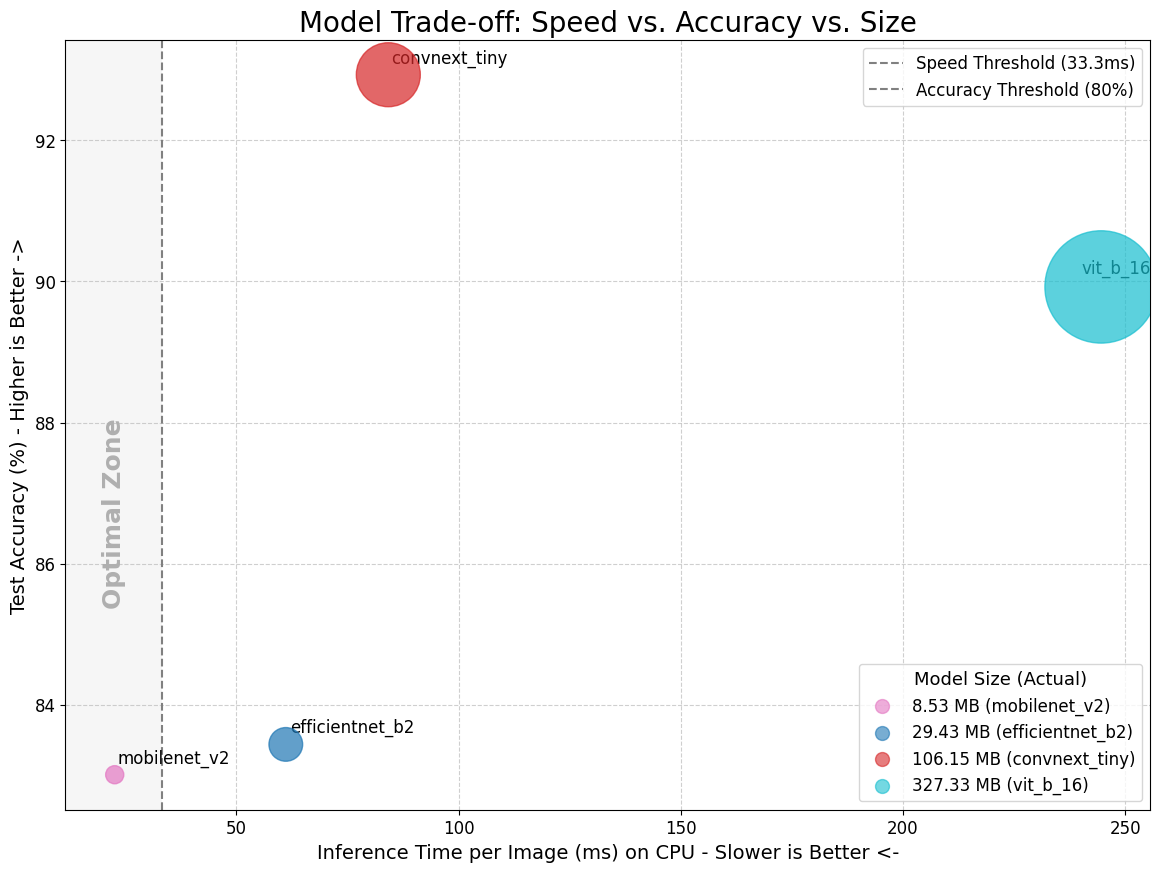

In [6]:
# --- 2. Visualize the Trade-offs for Final Decision ---

# While the table provides the precise numbers, a visual plot is essential for understanding
# the complex trade-offs between our three key metrics. The following function renders our
# `decision_df` onto a 3D scatter plot (2D axes + bubble size) to clearly identify
# which models reside in our predefined "Optimal Zone".
plot_tradeoff_scatter(decision_df)

**Trade-off Analysis Observations:**

> The trade-off scatter plot provides a definitive, at-a-glance summary of our multi-objective problem. It clearly illustrates the compromise between performance (accuracy) and efficiency (speed and size).
>- A Clear Winner Emerges: The most critical insight is that `mobilenet_v2` is the only model that successfully lands within the 'Optimal Zone'. It is the sole candidate that simultaneously meets both our primary requirements:
>    - It surpasses the **>80% accuracy threshold**.
>    - It satisfies the **>30 FPS (<33.3ms) inference speed** requirement.
>- High-Accuracy but Inefficient Models: While models like `convnext_tiny` and `vit_b_16` achieved higher peak accuracy, their slow inference times on a CPU make them unsuitable for our real-time deployment goal.
>- Hardware Dependency Note: It is important to acknowledge that the **inference time is hardware-dependent**. The benchmarks were conducted on a specific CPU, and these times will vary on different hardware. However, the *relative* speed differences between the models are likely to remain consistent.


## 04. Phase 1 summary & key takeaways

- **Performance Analysis:** The evaluation confirmed that **all four models** successfully surpassed our **80% accuracy threshold**, establishing them as viable candidates. `convnext_tiny` and `vit_b_16` were noted as the top performers in this category.

- **Efficiency Analysis:** Benchmarking revealed a clear efficiency leader. `mobilenet_v2` was the only model meeting the critical **>30 FPS inference speed requirement**, while also being, by a significant margin, the most lightweight architecture.

- **Trade-off Analysis:** The trade-off analysis was decisive. `mobilenet_v2` emerged as the unambiguous winner, as it was the only candidate to simultaneously satisfy all project criteria for accuracy, speed, and size.

- **Next Steps:** The project will now advance to Phase 2. The selected `mobilenet_v2` architecture will be trained on the full 101-class dataset. The final model will then be deployed as an interactive application on Hugging Face Spaces, allowing users to classify food images from their devices.